In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol

filename = "russell_prices.txt"
data = pd.read_csv(filename, sep=" ", skiprows = [0,1], header=None)
data = data.iloc[:,:-1]
data_pct = data.T.pct_change().iloc[1:,:]

In [0]:
#1
mean_return = data_pct.mean()
cov_matrix = data_pct.cov()

In [0]:
#2 Implement of algorithm

def feasible_initial(l,u):    #Initialization of lower bounds and upper bounds of each asset in the portfolio and return a feasible portfolio vector

    if l.sum()>1 or (~(l<=u)).sum()!=0:     
        print("Infeasible!")
    elif (u.cumsum())[-1]<1:
        print("infeasible!")       
    else:
        w=l.copy()
        count=0+l.sum()
        for i in range(len(w)):
            count+=u[i]-l[i] 
       
            if count<1:
              w[i]=u[i]
            elif count==1:
              w[i]=u[i]
              break
            else:
              w[i]=u[i]-(count-1)
              break
        return w


In [0]:
def Grad_Fx_wrt_x(lamda,w):
    grad=2*lamda*np.dot(cov_matrix,w)-mean_return
    return grad

In [0]:
def get_y(lamda,w, l, u):
  # sort the asset indices so that the gradient is from large to small and get a sorted y vector
  # loop m through 1 to 947
  # get a list of feasible y and choose the y that gives the min grad*y
  
  feasible_y=[]
  grad = Grad_Fx_wrt_x(lamda,w)
  grad_sorted = grad.argsort()[::-1]
  w_sorted = w[grad_sorted]
  for m in range(947):
    y=l-w_sorted
    y[m]=0
    y[m+1:]=(u-w_sorted)[m+1:]
    y[m]=0-np.sum(y)
    if y[m]>=(l-w_sorted)[m] and y[m]<=(u-w_sorted)[m]:    #use y[m] to check feasibility
      feasible_y.append(list(y))
  #print("len(feasible_y):",len(feasible_y))               #there will only be 1 feasible candidates    

  if len(feasible_y)==0:                    # when all candidate vectors are rejected, return an array of 0
    return np.repeat(0,len(w))
  
  min_grad_y=0
  y_opt=[]
  for i in feasible_y:
    if np.dot(grad[grad_sorted],i)<min_grad_y:           # if more than one candidate vector y give a same objective       
        min_grad_y=np.dot(grad[grad_sorted],i)           # we choose the y that comes first
        y_opt=i
  if y_opt == []:
    return np.repeat(0,len(w))
  
  # make the indices of the optimal y vector back to the original sequence
  y_opto = list(np.repeat(0,947))
  count = 0
  for i in grad_sorted: 
    y_opto[i] = y_opt[count]
    count = count+1
    if count == len(grad_sorted-1):
      break
    
  return np.array(y_opto)

In [0]:
def step_size(lamda,w,y):
  # derivative of F(x+sy) wrt.s = y*F(x+sy)=0
    s_up=np.dot(mean_return,y)/(2*lamda)-np.dot(np.dot(cov_matrix,w),y)
    s_down=np.dot(np.dot(cov_matrix,y),y)
    s=(s_up/s_down)
    if s<0:
        s=0
    elif s>1:
        s=1
    return s

In [0]:
def improve_f(lamda):
  # loop to get optimal F(x)

    l=np.repeat(0.0,947)      #have to enter an array of float 
    u=np.repeat(1,947)
    w = feasible_initial(l,u)
    
    #Get current portfolio F
    var_port,ret_port = var_ret(w)
    var_port = float(var_port.iloc[0][0])
    ret_port = float(ret_port.iloc[0])

    F_old = lamda * var_port - ret_port
    
    #Proceed to the next position w, and get new F value
    y=get_y(lamda,w, l, u)
    s=step_size(lamda, w,y)
    w=w+s*y
    
    var_port,ret_port = var_ret(w)
    var_port = float(var_port.iloc[0][0])
    ret_port = float(ret_port.iloc[0])
    F_new = lamda * var_port - ret_port
    
    #Calculate the improvement of the step
    dif = F_old - F_new
    
    #Keep finding new step until improvement is less than certain number
    while dif > 0.0000001:
      F_old = F_new
      y=get_y(lamda,w, l, u)
      s=step_size(lamda, w,y)
      w=w+s*y
      
      var_port,ret_port = var_ret(w)
      var_port = float(var_port.iloc[0][0])
      ret_port = float(ret_port.iloc[0])

      F_new = lamda * var_port - ret_port
      dif = F_old - F_new
   
    return w

In [0]:
def var_ret(w):                  #This function takes a portfolio as input and return the portfolio's return and variance
    w_vector = pd.DataFrame(w)
    var = w_vector.transpose().dot(cov_matrix).dot(w_vector)
    ret = w_vector.transpose().dot(mean_return)
    return var, ret

In [31]:
#3 When lambda = 0
lamda = 0
l = np.repeat(0.0, 947)
u = np.repeat(1, 947)
w = feasible_initial(l,u)
y = get_y(lamda, w, l, u)
s = step_size(lamda, w, y)
w = w + s*y
var_0= var_ret(w)[0]

print('Number of asset in the basket:',np.sum(w))
print('When lambda is 0, we do not consider risk in the portfolio, thus the basket has 1 asset of the highest return.')
print('variance of portfolio when lambda = 0 is:', var_0.iloc[0,0])

Number of asset in the basket: 1.0
When lambda is 0, we do not consider risk in the portfolio, thus the basket has 1 asset of the highest return.
variance of portfolio when lambda = 0 is: 0.018636783933845803


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


The smallest variance on the graph is  0.00013378265231662605 , it happens when lambda is  4.900000000000004


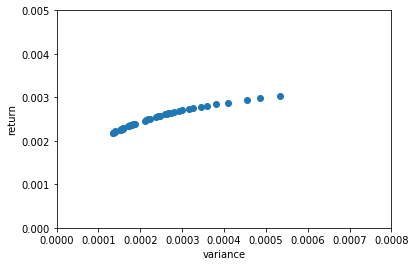

In [0]:
#4 When lambda takes range from 1 to 5, step size 0.1

var_array = np.array([])
ret_array = np.array([])
lamda_array = np.array([])

for i in np.arange(1,5,0.1):
  
  w=improve_f(i)
  var, ret = var_ret(w)
  var_array = np.append(var_array,var)
  ret_array = np.append(ret_array,ret)
  lamda_array = np.append(lamda_array, i)
  
  
plt.scatter(var_array, ret_array)
plt.xlabel('variance')
plt.ylabel('return')
plt.xlim(0, 0.0008)
plt.ylim(0, 0.005)
plt.show
print('The smallest variance on the graph is ', var_array.min(), ', it happens when lambda is ', lamda_array[var_array.argmin()])

In [41]:
#5
S_0 = 0.018636783933845803
S_min = var_array.min()
S_mid = 0.5*(S_0+S_min)
print('S_mid: ',S_mid)

lamda = 0.0946                 #estimation of lambda to achieve this variance
w=improve_f(lamda)

var = var_ret(w)[0].iloc[0,0]
print('At lambda = 0.0946, variance of the portfolio is: ', var)

S_mid:  0.009385283293081215
At lambda = 0.0946, variance of the portfolio is:  0.00938488669375063
